- title: tutorial: Deploying Code on Google Cloud
- date: 2020-11-16 12:00
- category: tutorial
- tags: python, google cloud
- slug: google cloud
- authors: Julien Hernandez Lallement
- summary: A tutorial on how to deploy code on GCloud
- illustration: 2020_11_gcloud.jpg

Since my transition from academia to the private sector, I realized that one extreme challenge that businesses face is the scalability of the processes they develop. In other words, building a process (might it be a simple data flow, a dashboard or a more complex ML pipeline) is one thing, but deploying that process so that execution and monitoring are scheduled, automatic and easy to debut is another. 

In this post, I will present a use case I faced in a project necessiting a dashboard to be updated on a daily basis, and how I used Google Cloud Platform (GCP) to scale up the project to allow automatic execution.

## Business case

In this project, I was asked to provide an interactive dashboard that monitored a series of KPIs and other indicators regarding digital communication in the company. 

The first steps, as usual, involved inquiring on data location, building data pipes, and finally building the dashboard. I have another [post](https://juls-dotcom.github.io/tableau&python.html) rather focused on such processes, so I won't be focusing on this aspect here.

Once the pipeline had been built, I needed to execute it every morning in order to feed the dashboard with fresh data. That was annoying. I needed to come up with a scaled system that allowed the execution of the pipeline on schedule, and allowed users to monitor that the pipeline was correctly executed.

## Google Cloud Platform

GCP is a terrific tool that gets virtually constant improvements and features. I learned how to use GCP on my own, so do not take my proceedings as best practice. There might be other functionnalities I am unaware of that would allow you to run this process in a more efficient way.

The first step was to export the pipeline on GCP to run it on the cloud.

#### Export pipeline on GCP

I first created a Virtual Machine instance on the GCP, under the `AI Platform / Notebooks`. This section provide `JupyterLab` interfaces that allow you to explore data in a notebook framework. 

Upon creation of the instance, you can **START**, the virtual machine. Note that you will get bill for running instances, so make sure you **STOP** them when done.

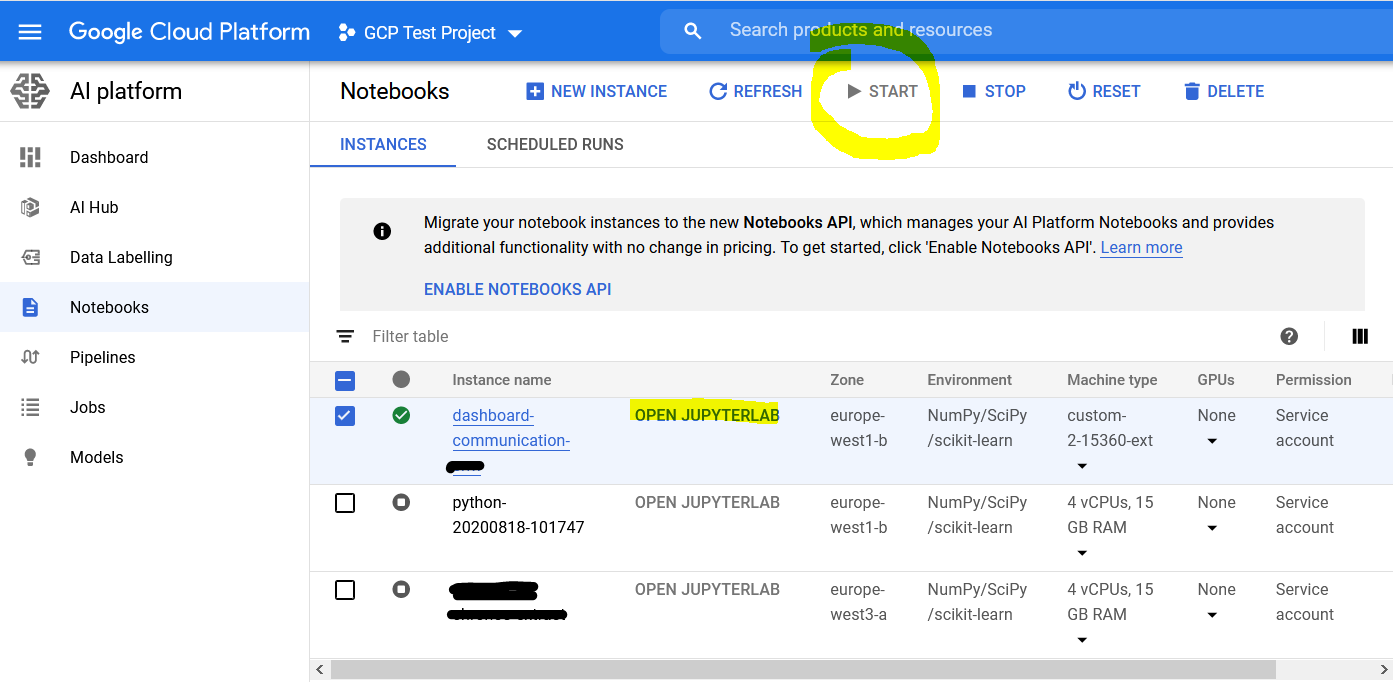

In [8]:
PATH = "C:\\Users\\jhernandez-lallement\\Documents\\GCP_post\\"
Image(filename = PATH + "Capture1.PNG", width=800, height=500)

Once in the `JupyterLab` interface, you can open a terminal and Git Clone your repository. I am assuming that the reader knows Git, and has its library pushed on some kind of online repository.

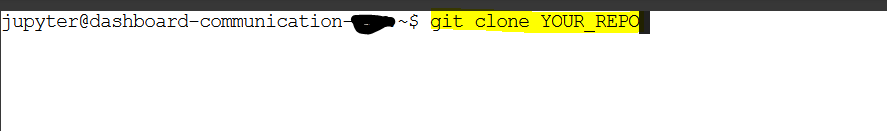

In [12]:
Image(filename = PATH + "GitClone.PNG", width=800, height=500)

Once your repo is cloned, you will get the folder containing your library copied on your VM, which in my case contained several files & folders, as displayed below:

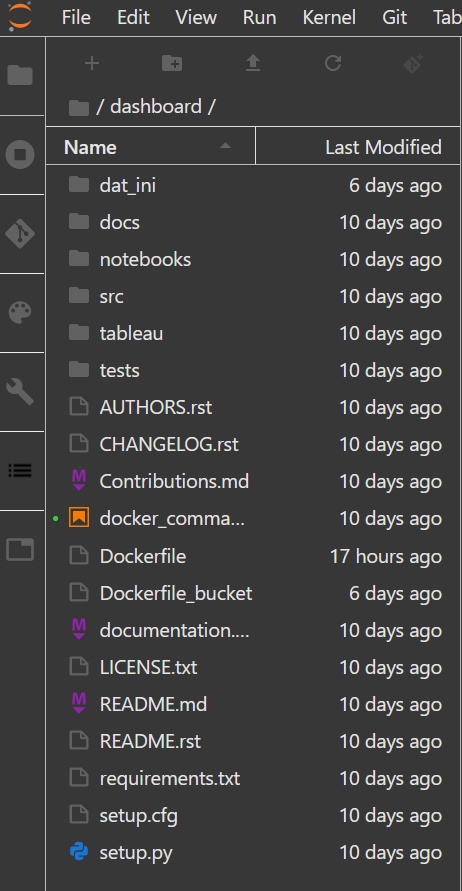

In [18]:
Image(filename = PATH + "Repo.PNG", width=350, height=200)

Now that your code is present on the cloud, you can run all your computations on the VM and make sure that everything works as expected. There might be some issues if you code was written under a different OS, so it always is a good idea to relaunch the code in here and make sure the output is the one needed.

#### Use Docker to containerize your code

Docker is kind of a lighteight virtual machine on its own, which contains all the components you need to run an application. While I found it [quite complicated](https://blog.hipolabs.com/understanding-docker-without-losing-your-shit-cf2b30307c63) to understand, you can see it as a bubble, a snapshot of an application that would allow yourself & others to re-run your code somewhere else under the exact same conditions. You can find more information on Docker [here](https://towardsdatascience.com/how-docker-can-help-you-become-a-more-effective-data-scientist-7fc048ef91d5), for now I will assume you know the basics of using Docker

Since you know the basics ;), you know that you should use a `Dockerfile` to specific how to build and run your container. The `Dockerfile` is a text file named exactly with that terminology, that contains all commands required to run your application.

You can create a Dockerfile in your folder root, and add commands as required by the project. In my case, it required following:
1. Run in Python environment -- <br>
`FROM Python: 3.8`
2. Copy a series of files in the container, including:
    * all .py files contained in source -- <br>
    `COPY ./src/jhl001_digital_communication ./`
    * project dependencies contained in requirements.txt -- <br>
    `COPY ./requirements.txt ./requirements.txt`
    * Google token credential file -- <br>
    `COPY ./dat_ini/mycreds.txt ./mycreds.txt`
    * access key to Google Account -- <br>
    `COPY ./dat_ini/client_secrets.json ./client_secrets.json`    
3. Install the necessary libraries <br>
    `RUN pip install -r requirements.txt`
* Run Python file <br>
    `ENTRYPOINT ["python", "run_pipe_all.py"] `

The file `run_pipe_all.py` contains the pipeline I needed to execute, all in one file. As a reminder, this pipeline fetched data in different locations, munged it, and exported it in another location to feed a Tableau Dashboard.

The file looked like that, with a few commented lines with files I did not need after testing.

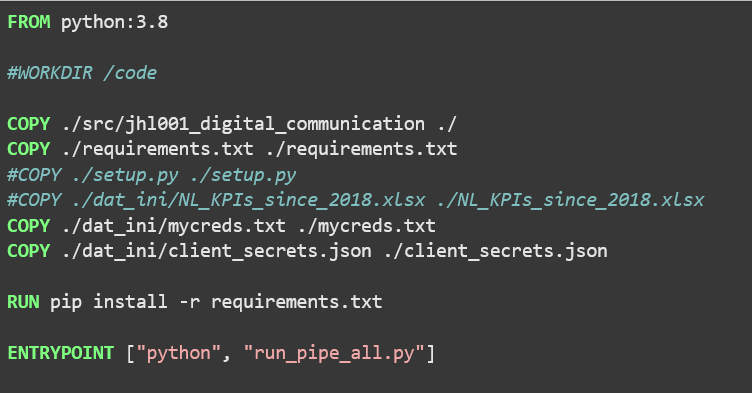

In [19]:
Image(filename = PATH + "DockerFile.PNG", width=350, height=200)

Nice! So everything is ready to build your container, which you can do easily by running the following line in the terminal

```docker build . -t gcr.io/PROJECT_NAME/CONTAINER_NAME:latest```

In my case, I am using a Test Project (you can find the ID of your project in the Project section of GCP) and I named  the container `dashboard`.
The `:latest` informs Docker that the container should be built as the latest version. 

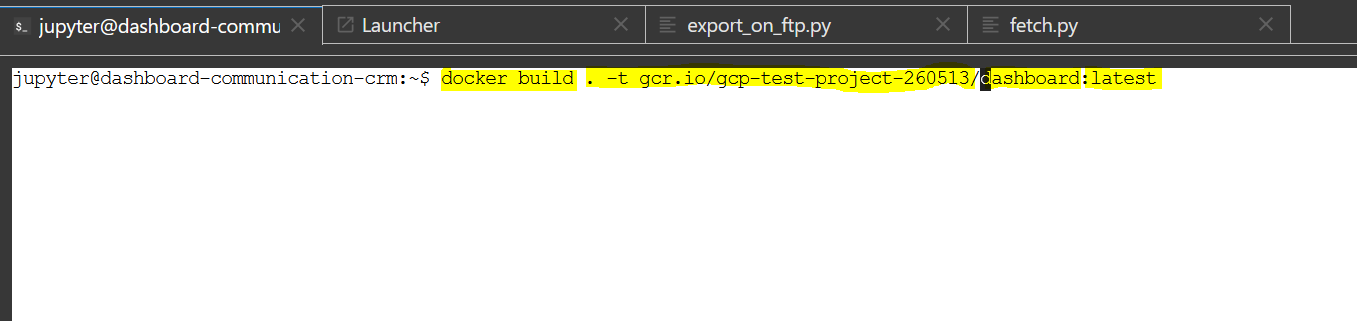

In [23]:
Image(filename = PATH + "container_build.PNG", width=500, height=500)

Now, you have containerized your application / code. Running the container should do the same as running the final line of code in your VM, where all dependencies have already been installed under your Python environment

You can test this by typing this command in the terminal

```docker run -ti gcr.io/PROJECT_NAME/CONTAINER_NAME:latest```

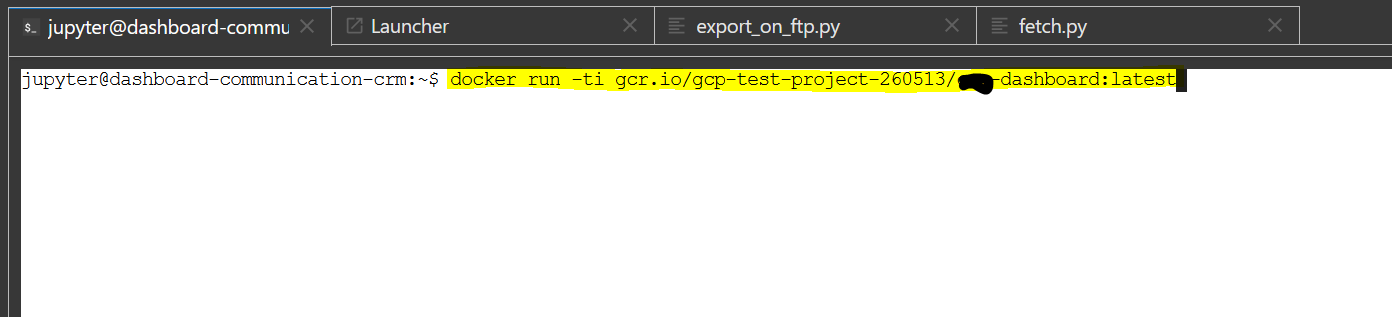

In [24]:
Image(filename = PATH + "container_run.PNG", width=500, height=500)

In my case, the python file is executed and the pipeline, which I put together into one single file is executed.

Good! Your code is now packed, and you can use this container to share it with others, or simply execute it easily through this interface.

Now, let's see if we can use other GCP features to factorize this code and execute it on regular schedules

#### Push container to Google Container Registry

In order to share your container, you can `push` it by using the command line below: 

```docker push gcr.io/PROJECT_NAME/CONTAINER_NAME:latest```

This will place your container on Container Registry to access it from other interfaces

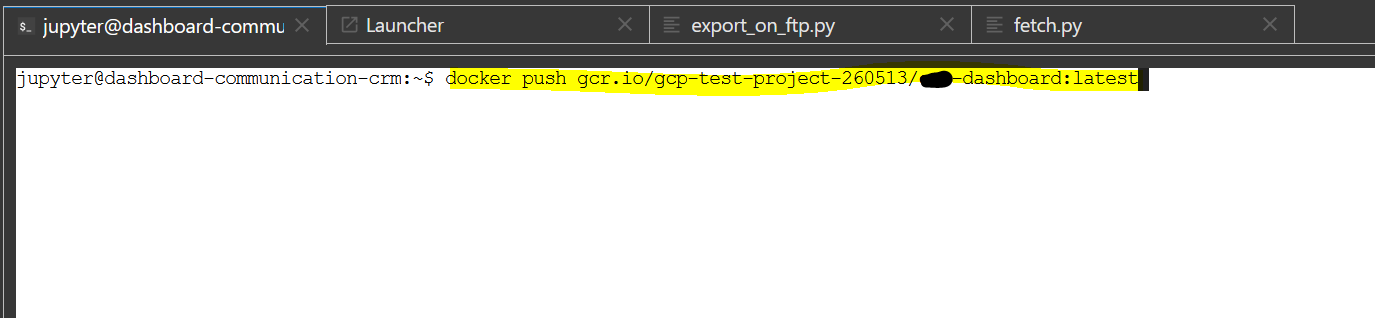

In [26]:
Image(filename = PATH + "container_push.PNG", width=500, height=500)

If you now go on Container Registry (left GCP toolbar), you should see your container located in the list

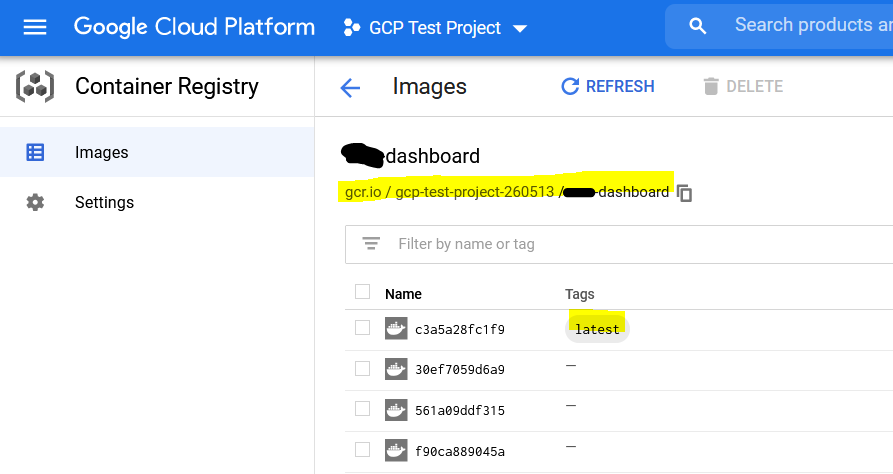

In [31]:
Image(filename = PATH + "Container_Registry.PNG", width=600, height=800)

You can see how my container, the `latest` image of it, is now present on Container Registry. FYI, an docker image is a blueprint of what needs to be built when running the container. 

Good, now you have your container image pushed. Let's use other GCP features to schedule its execution & monitoring!

#### Google Compute Engine (GCE)

Once your image is present on the registry, the next step is to deply the container on a GCE VM. One neat feature of GCE is that it will automatically provide a Container-Optimized OS with DOcker installer on it. This means that the **container will be executed as soon as the VM is launched**.

Below, you see the new VM called `update-dashboard` I created to host the container image. <br><br>
Note how the VM `dashboard-communication` created under the `AT Platform / Notebook` interface is also present in GCE. 

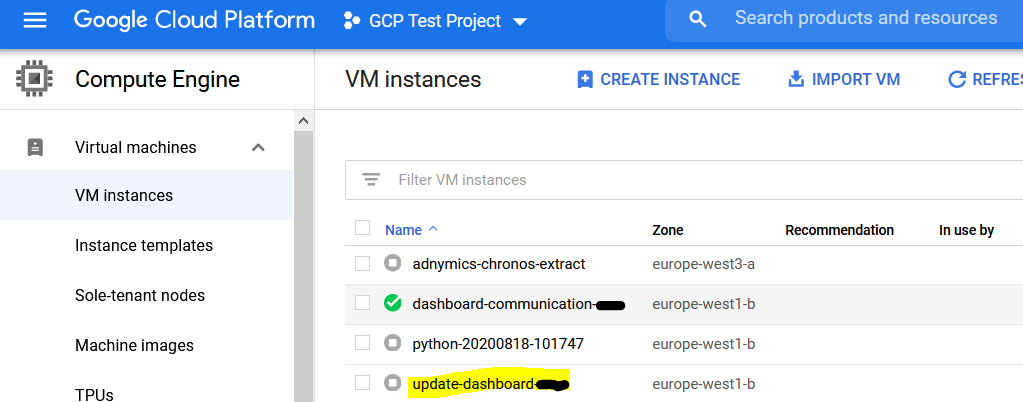

In [35]:
Image(filename = PATH + "GCE.PNG", width=600, height=800)

To do so: 
* Create a VM on GCE and set Region & Zone needed
* In the container section, check *Deploy a container image to this VM instance* 
* Provide the container image. This is the actual location of the container imager, which in my case is *fcr.io/gcp-test-project-260513/dashboard:latest*
* I set the * Restart Policy* to *On failure* and *Run as privileged* as * True* 
* Finally, tick the *Allocate a buffer for STDIN* and *Allocate a pseudo-TTY* boxes, since we required these options to link to the container. 

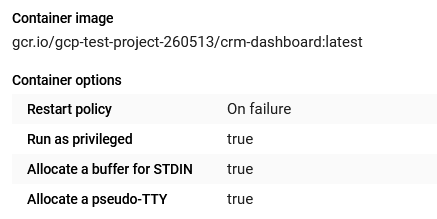

In [33]:
Image(filename = PATH + "GCE_Container.PNG", width=600, height=800)

Now your container is hosted in a GCE VM.

Let's now use two GCP components, `Cloud Scheduler` and `Cloud Functions`. I used this [Google documentation](https://cloud.google.com/scheduler/docs/scheduling-instances-with-cloud-scheduler) to implement these functionnalities, which is quite easy to follow.

#### Create Cloud Functions

The steps below are taken from the [Google documentation](https://cloud.google.com/scheduler/docs/scheduling-instances-with-cloud-scheduler), but I put them for consistency

To create a Cloud Function to start your VM instance:
1. Go to the Cloud Functions page
2. Create Function
3. Set Function Nae to startInstancePubSub
4. Leave Region at its default value.
5. For Trigger type, select Cloud Pub/Sub.
6. For Select a Cloud Pub/Sub topic, select Create a topic....
7. A New pub/sub topic dialog box should appear.

    * Under Topic ID, enter start-instance-event.
    * Click Create Topic to finish the dialog box.

8. Click Save at the bottom of the Trigger box.
9. Click Next at the bottom of the page.
10. For Runtime, select Node.js 10.
11. For Entry point, enter startInstancePubSub.
12. On the left side of the code editor, select index.js.

    * Replace the starter code with the following code:

In [ ]:
const Compute = require('@google-cloud/compute');
const compute = new Compute();

/**
 * Starts Compute Engine instances.
 *
 * Expects a PubSub message with JSON-formatted event data containing the
 * following attributes:
 *  zone - the GCP zone the instances are located in.
 *  label - the label of instances to start.
 *
 * @param {!object} event Cloud Function PubSub message event.
 * @param {!object} callback Cloud Function PubSub callback indicating
 *  completion.
 */
exports.startInstancePubSub = async (event, context, callback) => {
  try {
    const payload = _validatePayload(
      JSON.parse(Buffer.from(event.data, 'base64').toString())
    );
    const options = {filter: `labels.${payload.label}`};
    const [vms] = await compute.getVMs(options);
    await Promise.all(
      vms.map(async instance => {
        if (payload.zone === instance.zone.id) {
          const [operation] = await compute
            .zone(payload.zone)
            .vm(instance.name)
            .start();

          // Operation pending
          return operation.promise();
        }
      })
    );

    // Operation complete. Instance successfully started.
    const message = 'Successfully started instance(s)';
    console.log(message);
    callback(null, message);
  } catch (err) {
    console.log(err);
    callback(err);
  }
};

/**
 * Validates that a request payload contains the expected fields.
 *
 * @param {!object} payload the request payload to validate.
 * @return {!object} the payload object.
 */
const _validatePayload = payload => {
  if (!payload.zone) {
    throw new Error("Attribute 'zone' missing from payload");
  } else if (!payload.label) {
    throw new Error("Attribute 'label' missing from payload");
  }
  return payload;
};

14. On the left side of the code editor, select the package.json.
    * Replace the starter code with the following code:

In [ ]:
{
  "name": "cloud-functions-schedule-instance",
  "version": "0.1.0",
  "private": true,
  "license": "Apache-2.0",
  "author": "Google Inc.",
  "repository": {
    "type": "git",
    "url": "https://github.com/GoogleCloudPlatform/nodejs-docs-samples.git"
  },
  "engines": {
    "node": ">=10.0.0"
  },
  "scripts": {
    "test": "mocha test/*.test.js --timeout=20000"
  },
  "devDependencies": {
    "mocha": "^8.0.0",
    "proxyquire": "^2.0.0",
    "sinon": "^9.0.0"
  },
  "dependencies": {
    "@google-cloud/compute": "^2.0.0"
  }
}


15. Click Deploy

The Stop Function (if you need it) is created following the same steps, check out the Google Doc for the right code snippet.

Once you are done preparing the two functions, you should see them in the main pane:

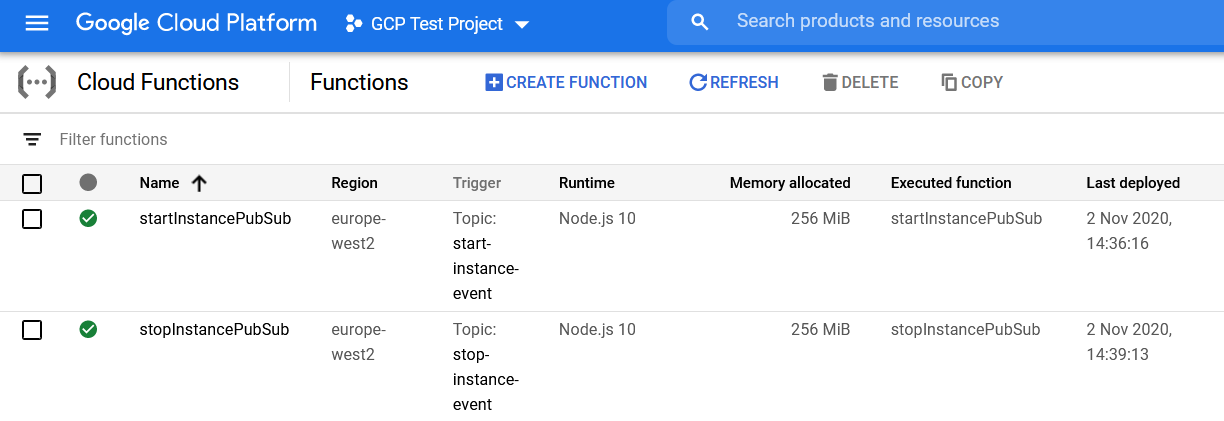

In [36]:
Image(filename = PATH + "CloudFunctions.PNG", width=600, height=800)

You can test that the function correctly starts the VM by entering the Function and going in the Test mode. Again, follow the Google Doc, which is very informative ;)

#### Use Google Scheduler to control your container/VM

The final step is to use Google Scheduler to define when the VM should be started and stopped. Since the container is launched upon initiation of the VM, launching it will automatically launch your code.

On the Google Scheduler page:
1. Create Job
2. Define Name
3. Enter Execution Frequency
    * This follows a CRON job syntax, which is very easy to understand. Check [this] if you are not familiar with that.
4. Select `Pub/Sub` in Target
5. Create a Topic, such as `start-VM-instance`

Now you need to specific the labels of the VM needed to be executed. This is done by looking up the labels of the VM in GCE. Go to the VM instance that you previously created in GCE and look up the label assigned. In this case, it is: `container-vm=cos-stable-85-13310-1041-24` 

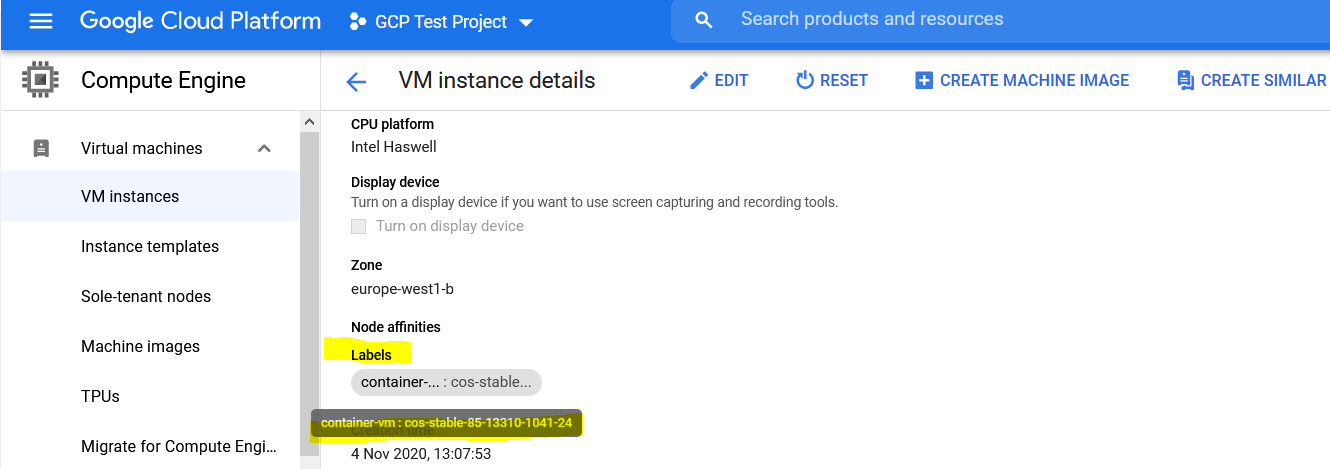

In [37]:
Image(filename = PATH + "label_GCE.PNG", width=600, height=800)

6. Thus, in the payload section of Cloud Scheduler, enter the following:
    * {"zone":"europe-west1-b", "label":"container-vm=cos-stable-85-13310-1041-24"}

You end up with this kind of window, which in my case defined a job to start each day at 6:35 in the morning:

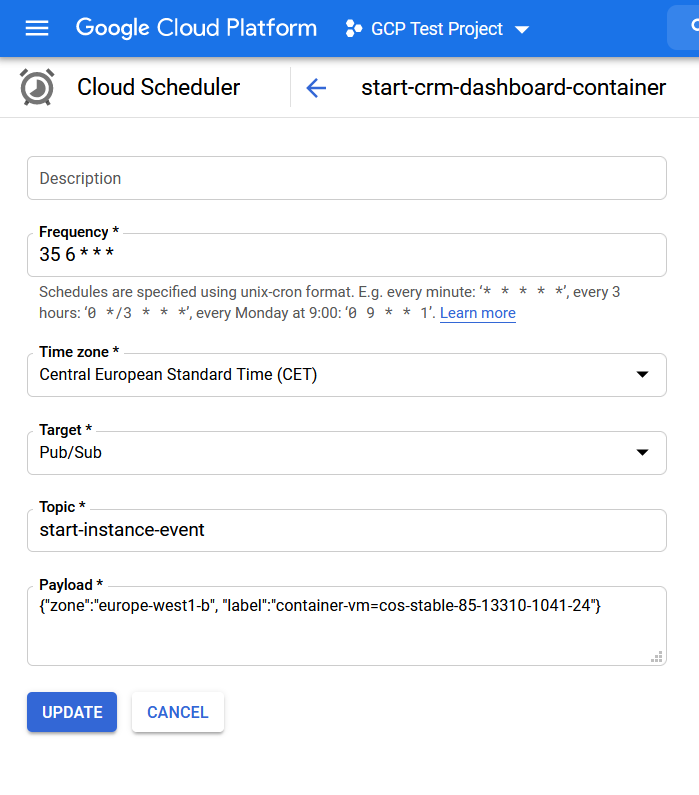

In [38]:
Image(filename = PATH + "CScheduler_Start.PNG", width=600, height=800)

You can create a stop scheduler Job by taking similar steps. 

This brings you to two scheduled jobs:

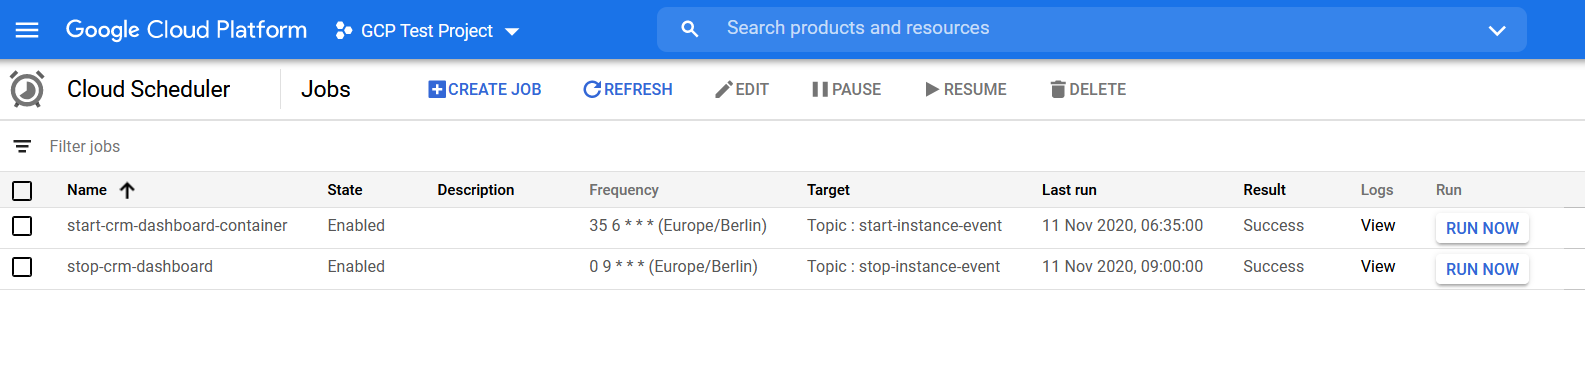

In [39]:
Image(filename = PATH + "Cloud_scheduler.PNG", width=600, height=800)

You can also test that the job is working correctly by pressing the `RUN NOW` button on the start and later stop job. They should launch and stop your GCE VM, respectively.

## DONE!

That's it! We have imported a repo on GCP, containerized it and used GCP features to schedule its execution. Monitoring of the process can be done relatively easily by accessing the `Logs` window in your GCE VM:

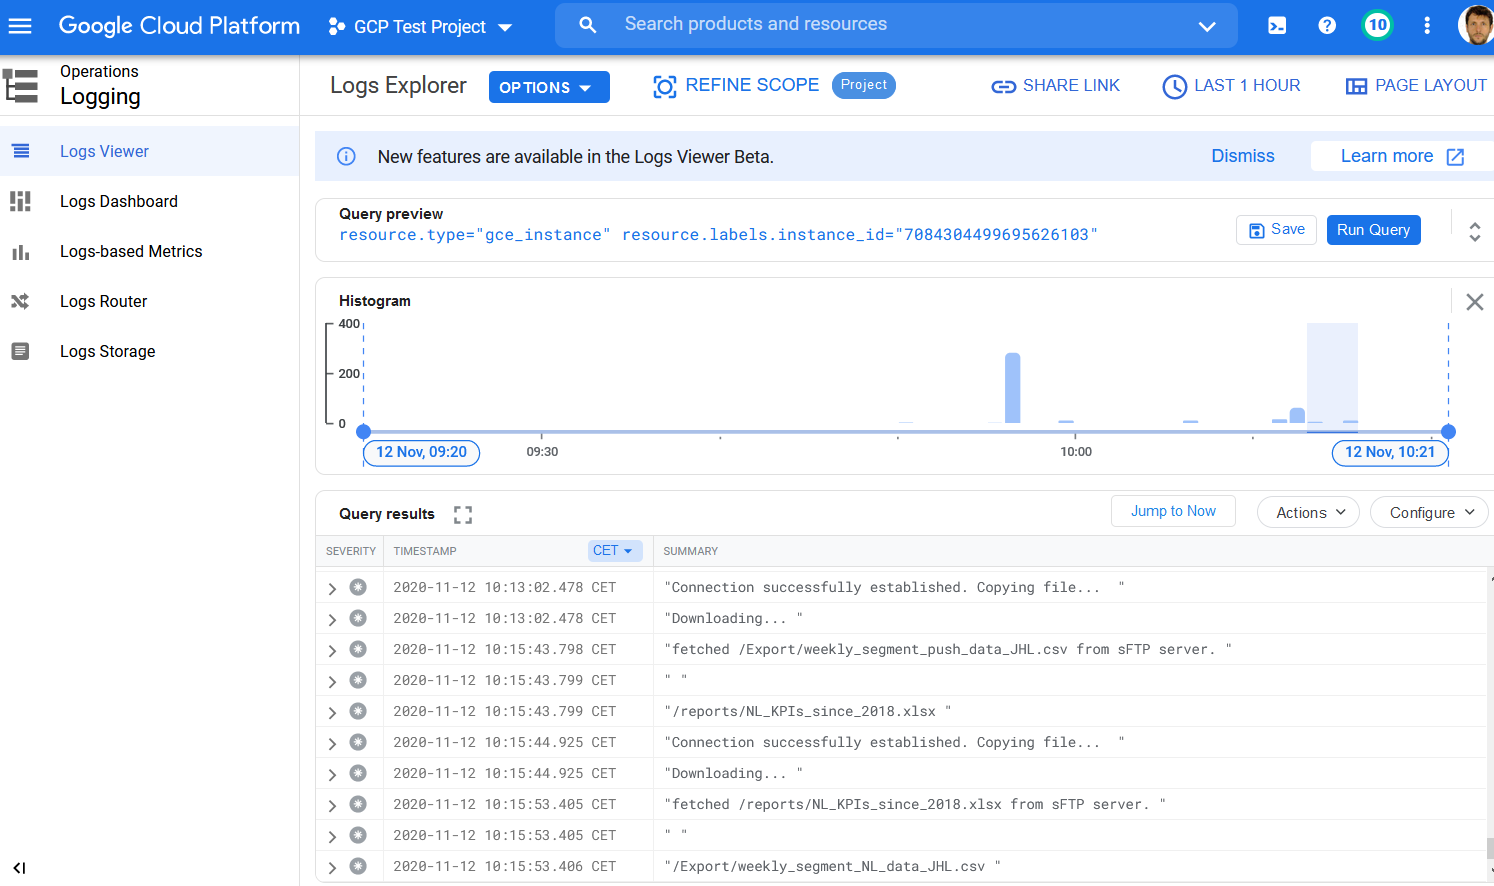

In [40]:
Image(filename = PATH + "logs.PNG", width=600, height=800)

This window will allow you to observe the logs of your code. As you can see from the screenshot above, I can see the `print` commands being outputed in each line, which can be useful to debut and monitor how your application was deployed and executed.

## Additional references

Here some references I used when performing this project
* [nice tutorial](https://minimaxir.com/2018/11/cheap-cron/) on how to use some of the GCP components I described here.
* [another tutorial](https://dragonprogrammer.com/deploy-docker-container-gcp/) that goes a bit more in detail to deploy apps on GCP